In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
#from util import *

In [2]:
%matplotlib inline
import matplotlib as plt

# 1. Skapande av mappar

In [1]:
from startup_tools import folder_maker

In [4]:
folder_maker(years=['2010','2014','2018'])

Utöver en korrekt mappstruktur för alla filer som hämtas från Valmyndigheten, samt den extraherade datan som plockas från dessa, så skapas också mappen 'redaktionsmaterial' med två mappar. Den ena är alla filer som är ämnade för redigeringen (tabeller som ska bli grafik i tidningen). Den andra heter 'valdata' och innehåller en mapp per reporter som ska skriva artiklar i valnumret.

# 2. Grunddata

## 2.1 Hämta grunddata från Valmyndigheten

Följande funktion hämtar alla xml-filer för valåren 2006-2018 och sparar dem i mappen 'xml_filer' under 'data'. Parametern "prelresultat" kan ändras till "valnatt" eller "slutresultat" för att hämta det som önskas för 2018. Åren 2010 och 2014 är alltid slutresultatet. Slutresultatet för 2018 är inte färdigt i skrivande stund. Det funktionen faktiskt gör är att hämta zipfilerna från Valmyndighetens URL, packa upp dem och spara ned dem i rätt mapp.

Viktigt att ha koll på är att all valdata är att data från 2006 hämtas från 2010:s valdata (där finns information om föregående val). Bortsett 2006 så kan detta innebära att vissa extraval som skett i landsting/kommuner inte kan kommit med för åren 2010-2018.

In [5]:
from startup_tools import xml_data_fetcher

In [6]:
%%time
xml_data_fetcher(count_type='prelresultat')

CPU times: user 3.4 s, sys: 1.35 s, total: 4.75 s
Wall time: 1min 31s


## 2.2 Extrahera grunddata från xml-filerna

XML-filerna kan sägas bestå av två olika filtyper. Dels tre stycken större filer som ger resultatet i varje val (kommun-, landstings- och riksdagsval) för nation/län/kommun. Det är dessa som modulen 'ExtractData' hämtar data från.

Utöver dessa finns tre filer per kommun -- en för varje val. Det är i kommunfilerna man hittar data på valkrets-/distriktsnivå. Dessa filer bearbetas inte av denna modul.

In [7]:
from startup_tools import ExtractData
E = ExtractData()

Nu en genomgång av de funktioner som används från modulen 'ExtractData':

- Metoden **fast_elec_calc()** bakar ihop valresultatet och sparar det i en excelfil enligt önskat upplägg. 

- Metoden **fast_particip_calc()** hämtar metadata från xml-filerna. Mer specifikt: valdeltagande i varje kommun, hur många som röstat totalt sett (exklusive blanka och ogilitiga röster) samt summan av hur många mandat som finns i respektive kommuns kommunfullmäktige/landstingsfullmäktige.

- **muni_elec_meta_data()** hämtar antalet valkretsar i varje kommun. Anledningen till varför detta är relevant är att för alla kommuner med endast en valkrets så är valspärren 2 procent, alla med fler än en valkrets har en valspärr på 3 procent för partier att få ett mandat. Alla partier som har ett valresultat under valspärren stryks från mandatfördelningsprocessen. (Denna är avkommenterad då den tar rätt lång tid och används sedan inte i resten av programmet)

- Metoden **all_parties()** hämtar metadata om alla partier som ställt upp i alla val 2006-2018.

- Slutligen, **macro_results** hämtar det samlade valresultatet för alla partier över hela riket i alla de tre valen åren 2006-2018. Resultatet sparas i filen 'alla_valresultat_2006_2018.xlsx' i mappen 'resultat'.

In [8]:
%%time

years = ['2010','2014','2018']

for year in years:
    E.fast_elec_calc(year=year,count_type="prelresultat")
    E.fast_particip_calc(year=year,count_type="prelresultat")
    #E.muni_elec_meta_data(year=year)

E.all_parties()
E.macro_results() 

CPU times: user 14.1 s, sys: 585 ms, total: 14.7 s
Wall time: 14.7 s


Här är kan man se hur resultatet av ovan fast_elec_calc() ser ut:

In [9]:
pd.read_excel('data/resultat/resultat_2018/valresultat_2018K.xlsx').head(1)

,kommun,kommunkod,mandat,mandat_fgval,parti,procent,procent_fgval,röster,röster_fgval
0,Karlshamn,1082,11.0,11.0,M,"21,2","19,6",4530,4079.0


Såhär ser resultatet av fast_particip_calc() ut:

In [10]:
pd.read_excel('data/meta_filer/valdeltagande/valdeltagande_2018K.xlsx').head(1)

,kommun,kommunkod,summa_mandat,summa_röstberättigade,summa_röstberättigade_fgval,summa_röster,summa_röster_fgval,valdeltagande,valdeltagande_fgval
0,Karlshamn,1082,51,25518,25295,21814,21142,85.5,83.6


# 3. Tidningsarbetet

Upplägget i följande kapitel är att varje artikelidé får ett eget underkapitel. Artikelidéerna består i många fall av flera frågeställningar och dessa har å sin tur fått egna underkapitel. Dessutom så följs artikelidéerna av ett underkapitel med underlag för redigeringen till tidningen (som sedan hamnar i mappen 'till_grafiken' i mappen 'redaktionsmaterial'). Alla artiklar har dock inte tilltänkt material till redigeringen.

Varje kapitel börjar med det som bestämdes under redaktionens valplaneringsmöte och emellanåt en kommentar på hur utfallet sedan blev under valveckans arbete.

## 3.1 Förstauppslaget - Lönade det sig att styra över blockgränsen?

#### 3.1.1 Bearbetning

Reporter: Johan D

Färre kommuner kan majoritetsstyras av blocken. Hur har det gått för de kommuner som haft blocköverskridande styren?

Vad som behövs för huvudvinkel

Data:
- Procent/mandat för alla partier i alla kommuner, 2006, 2010, 2014 och 2018.
- Styren i kommunerna, 2006, 2010, 2014 och 2018.

Beräkningar:
1. klassa alla styren som Borgerliga, vänster eller blocköverskridande (MP:s medverkan i alliansstyre leder inte till blocköverskridande)
2. Räkna samman totala röstandelar, och mandat för alla partier som inkluderas i styrena
3. Summera på totalen, per parti, och per typ av styre
4. jämför med tidigare val (dvs samma körningar på tidigare års data)

För kompletterande grafik

- De klassiska höger-/vänsterblockens möjligheter till majoriteter i alla kommuner. Samma som i förra valnumret.

Data:
- Sammanräknade röstandelar och mandat för höger-/vänsterblocken i alla kommuner (höger: allianspartierna, vänster: S+V)

Beräkningar:
1. Blockens röstandelar/mandat jämfört med totalen röster/mandat per kommun valen, 2006, 2010, 2014 och 2018.
2. Summering av antalet kommuner där högerblocket får majoritet för alla val
3. Summering av antalet kommuner där vänsterblocket får majoritet för alla val
4. Antalet kommuner där inget block får majoritet


In [11]:
from util import gov_mandates,block_gov_count

In [12]:
compare_year=2014

In [13]:
elec_year=2018

In [14]:
govs=gov_mandates(compare_year)

In [15]:
block=block_gov_count(govs,value='mandat',elec_year=elec_year,compare_year=compare_year)

block_gov_count() återger en lista med två items. Det första är en sammanfattade tabell med den infon vi tänkt dra på i tidningens förstauppslag. Det andra är en rak list apå alla kommuner. Kom ihåg att koden sorterar bort de kommuner som inte har partisammarbeten. Exempelvis är inte Munkfors med för 2018 då S där fick egen majoritet.

In [16]:
block[1]

block,BL,A,V
antal styren mandatperioden 2014-2018,102.0,93.0,78.0
antal styren som minskat sitt stöd i valet 2018,86.0,42.0,71.0
andelen av styren som minskat,84.3,45.2,91.0
"total mandatminskning i procent, 2018 jämfört 2014",-13.0,-1.1,-15.2
antal_majoritetsstyren_2014,87.0,48.0,49.0
antal_majoritetsstyren_2018,30.0,44.0,17.0


In [17]:
block[1].to_excel('redaktionsmaterial/valdata/JOHAN_blockstyren/väljarnas_dom_på_blocken_TOTALT.xlsx')

Följande är en grundtabell för mig och Gustav att jobba med i excel inför publicering ifall så behövs. Eller ifall vi vill kontrollera saker:

In [18]:
block[0].to_excel("redaktionsmaterial/valdata/JOHAN_blockstyren/grunddata/tabell_blocken.xlsx",index=False)
block_gov_count(govs,value='mandat',elec_year=elec_year,compare_year=compare_year,research_data=True)\
    .to_excel("redaktionsmaterial/valdata/JOHAN_blockstyren/grunddata/tabell_partierna.xlsx",index=False)

#### 3.1.2 Kompletterande grafik

Sara P vill ha en jämförelse liknande den som gjordes i förra valnumret. I denna så jämfördes de klassiska blockens möjligheter till att få en majoritet.

Följande beräkningar ska alltså svara på frågan: får något av de klassiska blocken en majoritet. Med klassiska block menas antingen S+V, eller allianspartierna. MP räknas inte in.

Vi börjar med S+V. Data blir resultatsfilerna med valresultaten.

In [19]:
from util import all_elec_years,majority_calc

In [20]:
df = all_elec_years('K')

In [21]:
majority_calc(df,operator='mandat')

,alliansen,vänstern,övriga
valår,,,
2006,118,70,102
2010,93,69,128
2014,36,57,197
2018,54,28,208


Ovan ser vi alltså i hur många kommuner alliansen (M+C+L+KD) hade tillsammans egen majoritet, samma för vänstern (S+V). Övriga är endast alla 290 kommuner minus allians- och vänstermajoriteter.

##### 3.1.2.1 till grafik

In [22]:
majority_calc(df,operator='mandat').to_excel("redaktionsmaterial/tabeller_till_grafik/2_3an_blockstyren_JOHAN_D/\
kompletterande_grafik_blockmajoriteter.xlsx")

In [23]:
majority_calc(df,operator='mandat').to_excel("redaktionsmaterial/valdata/JOHAN_blockstyren/antalet_kommuner_med_blockmajoritet_i_mandat.xlsx")

Varje reporter får också en README-fil med info om vad deras respektive mapp innehåller:

In [24]:
with open("redaktionsmaterial/valdata/JOHAN_blockstyren/README.txt","w") as f:
    f.write("""\
Denna mapps innehåll är tänkt till valnumrets 2-3:a. Filerna häri \
ger svar på hur blocken som styrde kommunerna 2014-2018 straffats \
av väljarna i om valet 2018. Här är en kortare genomgång av \
filerna som finns i mappen:

1. väljarnas_dom_på_blocken_TOTALT.xlsx
Denna fil innehåller en övergripande sammanställning som visar i \
hur många kommuner de olika blocken straffades av väljarna och \
fick minskat mandat. Blocken definieras såhär: A för Alliansstyre \
(M, C, L och KD) och V för Vänsterstyre (S och V). BL, dvs \
blocköverskridande styre, är där något av partierna i block A \
respektive V styrde tillsammans under mandatperioden. 

Eftersom målsättningen här är att se hur olika partiSAMARBETEN \
ansvarsutkrävs av väljarna är partier där endast ett parti styr \
bortsorterade (så även när något av de enskilda riksdagspartierna \
styr tillsammans med något lokalt parti).

2. väljarnas_dom_på_blocken_PER_KOMMUN.xlsx
Här hittar man den data som ovanstående sammanställning bygger på. \
I denna fil kollar man ifall man vill se hur det gått för någon \
särskild kommun.

3. antalet_kommuner_med_blockmajoritet_i_mandat.xlsx
**TÄNKT SOM POTENTIELL FÖRDJUPANDE GRAFIK**
Denna fil innehåller siffror på i hur många kommuner respektive \
traditionellt block fick egen majoritet (i mandat) i alla val \
sedan 2006. Det här är samma siffror som huvudgrafiken på 2-3:an \
i förra valnumret byggde på.
""")
    f.close

Ovanstående är kontrollräknat och stämmer. Det enda man bör ha i åtanke är att det i valdata kan vara enstaka kommuner som har haft omval tidigare år. T ex så hade Båstad ett sådant i juni 2015, där t ex M tappade två mandat. Men på det stora hela så spelar det ingen roll. Ovanstående beräkning skiljer sig från beräkningen i förra valtidningen där allianspartierna styrde två fler kommuner.

## 3.2 Så gick det för partierna i kommunvalen

#### 3.2.1 Intro

***Reporter: Samuel***

Att ta fram:
1. Partiernas resultat (röstandelar totalt?) i kommunvalet, 2006, 2010, 2014 och 2018.
2. Antalet kommuner där partierna ökar/backar, per parti, på valresultatet 2018.
3. Största lokala framgångarna/motgångarna - andel röster i en kommun jämfört med partiets andel i riket.
4. Starkaste fästena (de kommuner där det gick bäst/sämst, per parti)
5. Mandatfördelningen i kommunerna (antal och förändring jämfört valet 2014)
6. **I vilken kommun gör respektive riksdagsparti sin största ökning respektive sin största minskning jämfört med kommunvalet 2014? NY!!!**


In [25]:
from util import all_elec_years,valanalys,bästa_kommunen
import pandas as pd

In [26]:
elec_year = 2018
year_compare = 2014
elec_type = 'K'

#### **3.2.2 Partiernas resultat (röstandelar totalt?) i kommunvalet, 2006, 2010, 2014 och 2018.**

För att se ett samlat resultat för alla partier i kommunerna. Funktionen återger en lista där det första är listan av alla partiers valresultat i riket. Det andra används för fråga 3:

'K' för kommunval:

In [27]:
df = all_elec_years('K')

In [28]:
for year in [2006,2010,2014,2018]:
    valanalys(df,query='valresultat',elec_type='K',year=year)[0]\
    .to_excel(f'redaktionsmaterial/valdata/SAMUEL_kommunvalet/1_partiresultat_kommunvalet_2006_till_2018/\
valresultat_{year}K_TOTALT.xlsx',index=False)

valanalys() gör flera olika saker. Men med parametern query='valresultat' så hämtas en lista med två items. Det första är en sammanfattning på riksnivå med valresultatet summerat för varje parti. Parametern 'elec_type' tar vilket val man vill få summerat. Det andra item i listan är en dictionary med ett key-value-pari för varje parti.

In [29]:
valanalys(df,query='valresultat',elec_type='K',year=2018)[0]

,parti,procent,röster
0,C,9.5,628870
1,FI,0.9,61575
2,KD,5.1,337476
3,L,6.7,442623
4,M,19.7,1302561
5,MP,4.5,300079
6,S,27.1,1790500
7,SD,12.5,825822
8,V,7.5,498620
9,Övr,4.6,305328


Här är ett exempel på vad dictionaryn innehåller, här med C:s valresultat i kommunvalet:

In [30]:
valanalys(df,query='valresultat',elec_type='K',year=2018)[1]['C'].head()

,kommun,skillnad_jämf_riket,parti,valresultat_2018,andelar_riket
0,Jokkmokk,-9.0,C,0.5,9.5
1,Gällivare,-8.7,C,0.8,9.5
2,Fagersta,-8.0,C,1.5,9.5
3,Öckerö,-7.6,C,1.9,9.5
4,Landskrona,-7.3,C,2.2,9.5


##### 3.2.2.1 Till grafik

In [49]:
year=2018
year_compare=2014

In [50]:
grafik=pd.DataFrame()
grafik['parti']=valanalys(df,query='valresultat',elec_type='K',year=year)[0].loc[:,'parti']

In [51]:
for year in [2006,2010,2014,2018]:
    grafik=grafik.merge(valanalys(df,query='valresultat',elec_type='K',year=year)[0]\
                                  .rename(columns={
                                        'procent':f'procent_{year}K'
                                    }).loc[:,['parti',f'procent_{year}K']],on='parti',how='left')

In [52]:
grafik=grafik.loc[grafik['parti']!='FI']

In [53]:
grafik.to_excel('redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_kommunerna_SAMUEL/\
resultat_kommunval_2006_2018.xlsx',index=False)

#### **3.2.3 Antalet kommuner där partierna ökar/backar, per parti, på valresultatet 2018.**

För att se i hur många kommuner där partierna ökat/minskat i stöd:

In [54]:
valanalys(df,'jämför',year=year,year_compare=year_compare,elec_type='K',comp_type='ökat',sorter=False)

,party,antal_ökat_stöd,antal_minskat_stöd
0,C,207,83
1,KD,240,49
2,L,127,161
3,M,145,145
4,MP,3,287
5,S,40,250
6,SD,265,25
7,V,187,102
8,övriga,186,99


In [55]:
valanalys(df,'jämför',year=2014,elec_type='K',year_compare=2010,comp_type='ökat',sorter=False)\
    .to_excel(f'redaktionsmaterial/valdata/SAMUEL_kommunvalet/2_partiernas_stöd_i_kommunerna/\
stödet_i_kommunerna_SAMMANFATTNING.xlsx',index=False)

För att se i vilka kommuner där det gick bäst/sämst för ett visst parti. Denna kod triggas ifall man bestämmer parametern 'party'. I annat fall triggas partiernas framgångar/motgångar i kommunerna ovan.

In [56]:
for party in ['M','C','L','KD','S','V','MP','SD']:
    
    valanalys(df,'jämför',year=year,elec_type='K',year_compare=year_compare,party=party,sorter=True).reset_index()\
        .rename(columns={f'{party}':f'förändring {year_compare}-{year}'})\
        .to_excel(f"redaktionsmaterial/valdata/SAMUEL_kommunvalet/2_partiernas_stöd_i_kommunerna/resultat_per_parti/\
resultat_{party}.xlsx",index=False)

##### 3.2.3.1 Till grafik

In [57]:
grafik=valanalys(df,'jämför',year=year,elec_type='K',year_compare=year_compare,comp_type='ökat',sorter=False)
    

In [58]:
grafik.rename(columns={
    'party':'Parti',
    'antal_ökat_stöd':'Antal kommuner med ökat stöd',
    'antal_minskat_stöd':'Antal kommuner med minskat stöd'
},inplace=True)

In [59]:
grafik.to_excel('redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_kommunerna_SAMUEL/\
så_backar_och_ökar_partierna.xlsx',index=False)

#### **3.2.4 Största lokala framgångarna - andel röster i en kommun jämfört med partiets andel i riket**

Ovanstående funktion (fråga_3() i cellen ovan) används i valanalys(). För att få fram rätt resultat använder man 'valresultat' som query. Denna återger en lista där det andra i listan är en dictionary med varje partis 25 starkaste/svagaste fästen. 'sorter' avgör ifall de starkaste (False) eller svagaste (True) plockas fram:

In [60]:
df=all_elec_years(elec_type)

In [61]:
valanalys(df,query='valresultat',year=elec_year,elec_type=elec_type,sorter=False)[0]

,parti,procent,röster
0,C,9.5,628870
1,FI,0.9,61575
2,KD,5.1,337476
3,L,6.7,442623
4,M,19.7,1302561
5,MP,4.5,300079
6,S,27.1,1790500
7,SD,12.5,825822
8,V,7.5,498620
9,Övr,4.6,305328


In [62]:
a_dict=valanalys(df,query='valresultat',year=elec_year,elec_type=elec_type,sorter=False)[1]

In [63]:
for party in ['M','C','L','KD','S','V','MP','SD']:
    
    valanalys(df,query='valresultat',year=elec_year,elec_type=elec_type,sorter=False)[1][party]\
        .to_excel(f"redaktionsmaterial/valdata/SAMUEL_kommunvalet/3_största_lokala_framgångarna/\
resultat_{party}.xlsx",index=False)

##### 3.2.4.1 Detta är en omplettering till grafiken, ska till Påhls SD-artikel

In [64]:
df1=valanalys(df,year=elec_year,
                    elec_type=elec_type,
                    query='strong_holds',
                    sorter=False)['SD']
            #.to_excel(f"../valdata/SAMUEL_kommunvalet/\
#4_starkaste_fästena/resultat_{party}.xlsx",index=False)

In [65]:
df2=valanalys(df,year=elec_year,
                    elec_type=elec_type,
                    query='strong_holds',
                    sorter=True)['SD']

In [66]:
df2['parti'] = 'SD'
df1['parti'] = 'SD'

In [67]:
df2['parti'] = 'SD'
df1['parti'] = 'SD'

In [68]:
df1.to_excel('redaktionsmaterial/tabeller_till_grafik/SD_så_gick_det_PÅHL/31_SD_största_stöd.xlsx',index=False)

In [69]:
df2.to_excel('redaktionsmaterial/tabeller_till_grafik/SD_så_gick_det_PÅHL/31_SD_största_stöd.xlsx',index=False)

##### 3.2.4.2 Till grafik

In [70]:
from util import all_elec_years,riks_mot_kommun

In [71]:
elec_year=2018

In [72]:
df_riks = all_elec_years('R')

df_kommun = all_elec_years('K')

In [73]:
%%time
framgångar = riks_mot_kommun(df_riks,df_kommun,elec_year=elec_year,sorter=False)
motgångar = riks_mot_kommun(df_riks,df_kommun,elec_year=elec_year,sorter=True)

CPU times: user 7.67 s, sys: 81.3 ms, total: 7.75 s
Wall time: 7.8 s


In [74]:
framgångar

,Parti,Kommun,"Riksdagsvalet, %","Kommunvalet, %",Differens
0,M,Östra Göinge,18.2,42.2,24.0
1,L,Landskrona,6.7,34.3,27.6
2,C,Orsa,11.1,41.9,30.8
3,KD,Laxå,9.4,39.1,29.7
4,S,Grums,41.3,56.3,15.0
5,V,Degerfors,10.2,35.6,25.4
6,MP,Gällivare,2.5,11.9,9.4
7,SD,Tranås,19.5,19.6,0.1


In [75]:
framgångar.to_excel('redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_kommunerna_SAMUEL/\
partiernas_största_lokala_framgångar.xlsx',index=False)
motgångar.to_excel('redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_kommunerna_SAMUEL/\
partiernas_största_lokala_motgångar.xlsx',index=False)

#### **3.2.5 Starkaste fästena (de kommuner där det gick bäst/sämst, per parti)**

In [76]:
df=all_elec_years('K')

Funktionen valanalys() tar argumentet 'strong_holds' för att räkna fram en dictionary med alla de 25 starkaste/svagaste kommunera per parti:

In [77]:
parties = valanalys(df,year=elec_year,elec_type=elec_type,query='strong_holds',sorter=False)

In [78]:
parties['M'].head()

,kommun,procent
12359,Vellinge,50.5
14082,Essunga,43.0
12320,Staffanstorp,42.8
12230,Östra Göinge,42.2
12901,Trosa,40.6


Följande skapar en fil per parti med resultatet i alla kommuner:

In [79]:
for party in ['M','C','L','KD','S','V','MP','SD']:
    
    valanalys(df,year=elec_year,elec_type=elec_type,query='strong_holds',sorter=False)[party]\
        .to_excel(f"redaktionsmaterial/valdata/SAMUEL_kommunvalet/4_starkaste_fästena/\
resultat_{party}.xlsx",index=False)

##### 3.2.5.1 Till grafik

In [80]:
df = all_elec_years('K')

In [81]:
bästa_kommunen(df,elec_year)

,Parti,Starkaste fästet,"Kommunvalet, %"
0,M,Vellinge,50.5
1,C,Nordmaling,42.5
2,L,Landskrona,34.3
3,KD,Markaryd,39.5
4,S,Munkfors,63.5
5,V,Sorsele,36.5
6,MP,Jokkmokk,13.7
7,SD,Hörby,35.4


In [82]:
bästa_kommunen(df,elec_year)\
    .to_excel('redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_kommunerna_SAMUEL/\
de_starkaste_fästena.xlsx',index=False)

#### **3.2.6 Mandatfördelningen i kommunerna (antal och förändring jämfört valet 2014)**

In [83]:
df=all_elec_years('K')

In [84]:
valanalys(df,year=elec_year,elec_type=elec_type,year_compare=year_compare,query='mandates',sorter=False).sort_values('kommun').head()

,kommun,parti,mandat_2018,summa_mandat_2018,mandat_2014,summa_mandat_2014,skillnad_2018_2014
1916,Ale,S,13.0,49,17.0,49,-4.0
1915,Ale,KD,2.0,49,2.0,49,0.0
1918,Ale,MP,2.0,49,3.0,49,-1.0
1917,Ale,V,4.0,49,3.0,49,1.0
1914,Ale,L,2.0,49,2.0,49,0.0


In [85]:
valanalys(df,
          year=elec_year,
          elec_type=elec_type,
          year_compare=year_compare,
          query='mandates',
          sorter=False).sort_values('kommun')\
    .to_excel(f"redaktionsmaterial/valdata/SAMUEL_kommunvalet/5_mandatfördelning/\
mandatfördelning_kommunvalet_{elec_year}.xlsx",index=False)

#### 3.2.7 README

In [86]:
with open("redaktionsmaterial/valdata/SAMUEL_kommunvalet/README.txt","w") as f:
    f.write("""\
I den här mappen hittar man tabeller som visar resultatet i \
kommunvalet 2018. Materialet är tänkt till Samuels jobb som \
har arbetsnamnet "Så gick det i kommunerna".

Mapparna är givna siffror för att lättare kunna navigera. \
Här följer en presentation av vad mapparna innehåller:

- 1_partiresultat_kommunvalet_2006_till_2018
I denna mapp hittar man en fil per val 2006-2018. I dessa finns \
valresultatet i kommunvalen per parti på riksnivå. Det är alltså \
aggregerad data där partiernas procentsats bygger på samtliga \
röster de fått i alla kommuner.

- 2_partiernas_stöd_i_kommunerna
I denna mapp finns två olika typer av datafiler. Dels en fil som \
visar i hur många kommuner vari partierna har ökat eller minskat \
sitt väljarstöd. Så i kolumnen 'antal_ökat_stöd' ser man antalet \
kommuner där partiet i fråga har fått ett utökat väljarstöd. \
Detta bygger på skillnad i procent jämfört förra valet.

Sedan finns också en mapp med en fil per parti. Här är det en rak \
lista på hur det gick för partierna i alla kommuner jämfört med \
förra valet. Visar skillnaden i stöd i procentenheter.

- 3_största_lokala_framgångarna
I denna mapp finns också en fil per parti. Varje fil visar med \
hur många procentenheter partiets resultat i kommunvalet \
skiljer sig från deras samlade resultat i kommunvalet. \
Ta KD som exempel: i valet 2014 fick KD 44,94 procent av \
rösterna i Markaryd, medan de på aggregerad nivå i hela landet \
fick 3,98 procent av alla röster i kommunvalen. I den här \
mappen hittar man partiernas resultat i riket, i alla kommuner \
samt skillnaden däremellan.

- 4_starkaste_fästena
Också här en fil per parti. Här är det endast det endast \
skillnaden mellan resultatet i alla kommuner för partiet, \
jämfört resultatet för kommunen i hela landet i kommunvalet. \
Så samma som i mapp 3 ovan, men endast med skillnaden per kommun.

- 5_mandatfördelning
Här hittar man en fil som visar mandatfördelningen över alla \
mandat för partier som fått ett sådant, i alla kommuner.


""")
    f.close

## 3.3 Så gick det i landstingen

#### 3.3.1 Intro

**Reporter: Hans**

- Kommer något nytt parti in någonstans?

Beräkningar:
1. Mandatfördelningen per parti i landstingen 2014 och 2018
2. Landstingen där respektive parti får starkast stöd
3. Största lokala framgångarna/motgångarna - andel röster lokalt jämfört med riks
4. Antal mandat för alla sjukvårdspartier
5. Så fördelades landstingsrösterna (per parti) 2010, 2014, 2018 (NY!!)

Jag har precis räknat om alla länsfiler på korrekt vis så mandatfördelning är som det ska

In [87]:
import pandas as pd

In [88]:
from util import all_elec_years,\
                 mandates_per_parti_in_total,\
                 strongest_region,valanalys,\
                 vård_partier,\
                 elec_macro_fetcher

In [89]:
elec_year = 2018
compare_year = 2014
elec_type = 'L'

#### 3.3.2 Mandatfördelningen per parti i landstingen 2014 och 2018

In [90]:
df=all_elec_years(elec_type)

In [91]:
mandates_per_parti_in_total(df,elec_year=elec_year,compare_year=compare_year)

,parti,mandat_2018,mandat_2014,förändring_2014_2018
0,C,155.0,125.0,30.0
1,FI,0.0,0.0,0.0
2,KD,120.0,85.0,35.0
3,L,95.0,96.0,-1.0
4,M,315.0,339.0,-24.0
5,MP,48.0,106.0,-58.0
6,S,525.0,603.0,-78.0
7,SD,224.0,161.0,63.0
8,V,141.0,121.0,20.0
9,Övr,73.0,42.0,31.0


In [92]:
mandates_per_parti_in_total(df,elec_year=elec_year,compare_year=compare_year)\
    .to_excel(f"redaktionsmaterial/valdata/HANS_landstingsvalen/1_mandatfördelning/\
mandatförändring_{compare_year}_{elec_year}.xlsx",index=False)

##### 3.3.2.1 Till grafiken

In [93]:
mandates_per_parti_in_total(df,elec_year=elec_year,compare_year=compare_year)\
    .to_excel(f"redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_landstingen_HANS/\
mandatfördelningen_i_landstingen.xlsx",index=False)

#### 3.3.3 Landstingen där respektive parti får starkast stöd

In [94]:
df=all_elec_years(elec_type)

In [95]:
strongest_region(df,elec_year=elec_year)

,landsting,parti,valresultat_procent
0,Hallands län,M,23.2
1,Jämtlands län,C,20.4
2,Stockholms län,L,8.0
3,Jönköpings län,KD,12.7
4,Västernorrlands län,S,35.5
5,Västerbottens län,V,13.5
6,Stockholms län,MP,5.6
7,Blekinge län,SD,20.6
8,Norrbottens län,Övr,34.7


In [96]:
strongest_region(df,elec_year=elec_year)\
    .to_excel(f"redaktionsmaterial/valdata/HANS_landstingsvalen/2_starkaste_stödet/\
partiernas_starkaste_landsting_{elec_year}.xlsx",index=False)

##### 3.3.3.1 Till grafik

In [97]:
strongest_region(df,elec_year=elec_year)\
    .to_excel(f"redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_landstingen_HANS/\
partiernas_starkaste_fästen.xlsx",index=False)

#### 3.3.4 Största lokala framgångarna - andel röster lokalt jämfört med riks

In [98]:
df=all_elec_years(elec_type)

In [99]:
a_dict=valanalys(df,query='valresultat',year=elec_year,elec_type=elec_type,sorter=False)[1]

In [100]:
a_dict['C'].head()

,kommun,skillnad_jämf_riket,parti,valresultat_2018,andelar_riket
0,Jämtlands län,12.2,C,20.4,8.2
1,Kalmar län,3.6,C,11.8,8.2
2,Hallands län,3.4,C,11.6,8.2
3,Dalarnas län,3.2,C,11.4,8.2
4,Västerbottens län,3.1,C,11.3,8.2


In [101]:
for party in ['M','C','L','KD','S','V','MP','SD','FI']:
    
    valanalys(df,query='valresultat',year=elec_year,elec_type=elec_type,sorter=False)[1][party]\
        .to_excel(f"redaktionsmaterial/valdata/HANS_landstingsvalen/\
3_största_lokala_framgången/resultat_{party}_{elec_year}.xlsx",index=False)

#### 3.3.5 Antal mandat för alla sjukvårdspartier

Textsök på alla partier som matchas mot metadatan om partibeteckningar?

Hans har skickat en lista på alla sjukvårdspartier. Sammanlagt 11. Men alla dessa finns inte utskrivna i valdatat. Kanske då de gömts under kategorin "överiga_partier" av valmyndigheten. Nu har jag iaf lagt till en parameter som heter 'acronyms', och sätts denna på True så hämtas dessa sex från deras akronymer i valdatan.

Alla vårdpartier:

- Sol-partiet Sölvesborg och Lister
- Dalarnas sjukvårdsparti
- Sjukvårdspartiet Gävleborg
- Bevara akutsjukhusen
- Sjukvårdspartiet i Jönköpings län
- Sjukvårdspartiet
- Vård för pengarna
- Sjukvårdspartiet i Värmland
- Sjukvårdspartiet Västernorrland
- Regionens framtid
- Sjukvårdspartiet Västra Götaland

Akronymer = ['SoL','SJPG','SJV','VåfP','dsp','SJVP','BA','Rf','SPVG']

In [102]:
df = all_elec_years(elec_type)

Följande funktion använder sig av en textsökfunktion i tabellen. Parametern 'pattern' tar en textsträng och tabellen kommer sedan filtreras efter alla partier som har den texten i namnet. Stora eller små bokstäver spelar ingen roll.

I slutändan använde vi inte denna metod utan nöjde oss med att skriva in alla vårdpartiers partiförkortningar och helt enkelt endast söka efter detta. Det gör man genom att sätta parametern 'acronyms' till True. Med False så kommer sökmönstret gälla.

In [103]:
vård_partier(df,pattern='vård',elec_year=elec_year,drop=True,acronyms=False)

,kommun,valår,parti,röster,summa_röster,procent,mandat,summa_mandat,beteckning
38,Gävleborgs län,2018,SJPG,13131.0,188714,7.1,5.0,75,Sjukvårdspartiet Gävleborg
121,Norrbottens län,2018,SJV,57693.0,168757,34.7,27.0,71,Sjukvårdspartiet
213,Västernorrlands län,2018,SJVP,13981.0,164530,8.7,7.0,77,Sjukvårdspartiet - Västernorrland


In [104]:
vård_partier(df,pattern='vård',elec_year=elec_year,drop=True,acronyms=True)

,kommun,valår,parti,röster,summa_röster,procent,mandat,summa_mandat,beteckning
38,Gävleborgs län,2018,SJPG,13131.0,188714,7.1,5.0,75,Sjukvårdspartiet Gävleborg
77,Jönköpings län,2018,BA,20302.0,232245,8.9,7.0,81,Bevara akutsjukhusen
121,Norrbottens län,2018,SJV,57693.0,168757,34.7,27.0,71,Sjukvårdspartiet
213,Västernorrlands län,2018,SJVP,13981.0,164530,8.7,7.0,77,Sjukvårdspartiet - Västernorrland


In [105]:
vård_partier(df,pattern='vård',elec_year=elec_year,drop=True,acronyms=True)\
    .to_excel(f"redaktionsmaterial/valdata/HANS_landstingsvalen/\
4_sjukvårdspartierna/sjukvårdspartierna_{elec_year}.xlsx",index=False)

#### 3.3.6 Så fördelades landstingsrösterna (per parti) 2010, 2014, 2018

In [106]:
elec_macro_fetcher(elec_type=elec_type,
                   elec_years=[2010,2014,2018],
                   pivot_value='procent',
                   all_parties=False)

val,procent_2010L,procent_2014L,procent_2018L
parti,,,
C,6.17,6.31,8.4
FI,NaN,1.08,0.7
KD,5.07,5.17,7.1
L,7.48,6.28,6.3
M,27.29,21.51,19.3
MP,6.85,7.21,4.1
S,33.04,32.90,28.7
SD,4.58,9.14,12.9
V,5.77,7.08,8.6


In [107]:
elec_macro_fetcher(elec_type='L',
                   elec_years=[2010,2014,2018],
                   pivot_value='procent',
                   all_parties=False)\
    .to_excel("redaktionsmaterial/valdata/HANS_landstingsvalen/\
5_resultat_åren_2010_2018/resultat_2010_2018.xlsx")

#### 3.3.7 README

In [108]:
with open("redaktionsmaterial/valdata/HANS_landstingsvalen/README.txt","w") as f:
    f.write("""\
Här är en kortare beskrivning om denna mapps innehåll. Men \
först är det viktigt att omedelbart framhlla att det Gotland \
är med i SAMTLIGA av dessa filer. Detta kan ge en viss diff \
från Valmyndighetens data då Gotland inte är med i denna \
(Gotland har formellt inget landstingsval).

Här är en beskrivning av mapparnas innehåll:

1_mandatfördelning

I denna mapp finns en fil som visar hur många mandat partierna \
fick totalt i alla landsting, jämfört med vad de fick i förra \
valet. 

2_starkaste_stödet

I denna fil ser man i vilket landsting som samtliga partier \
har sitt starkaste stöd, plus vilken procent de där erhöll. 

3_största_lokala_framgången

I filerna i denna mapp (en fil per parti) ser man hur partiets \
stöd skiljer sig mot deras stöd i landstingsvalen totalt sett \
över hela landet, och skillnaden däremellan. Tabellerna är \
sorterade efter där partiet har starkast stöd (i procent). \
Notera att rikssiffran är EXKLUSIVE Gotland, då det inte är ett \
landstingsval.

4_sjukvårdspartierna

Här får man allmän valinfo om hur det gick för alla sjukvårds-\
partier i valet. Denna kan behövas bearbetas något då det är \
grundinfo.

5_resultat_åren_2010_2018

I denna fil finner man alla partiers valresultat (över riket) \
i procent i landstingsvalen åren 2010-2018. Dessa är också \
exklusive Gotland då de bygger rakt av på Valmyndighetens \
resultatfiler.

""")
    f.close

##### **Till grafik**

In [109]:
grafiken = elec_macro_fetcher(elec_type=elec_type,
                   elec_years=[2010,2014,2018],
                   pivot_value='procent',
                   all_parties=False)

In [110]:
for col in grafiken.columns:
    grafiken[col] = grafiken[col].round(1)
    grafiken = grafiken.rename(columns={col:col.replace('_',' ').replace('L','')})

In [111]:
grafiken.to_excel("redaktionsmaterial/tabeller_till_grafik/så_gick_det_i_landstingen_HANS/\
valresultat_2010_till_2018.xlsx")

## 3.4 Intervju: Wannholt i Göteborg

#### 3.4.1 Intro

Reporter: Micke Bergling

Detta jobb är en intervju med partiet Demokraternas partiledare i Göteborg. Ett parti som redan på förhand antogs göra ett succéval. Intervjun var tänkt att kompletteras med valresultatet i Göteborgs kommun.

#### 3.4.2 Bearbetning

In [112]:
from util import muni_sorter,all_elec_years

In [113]:
df = all_elec_years('K')

In [114]:
muni_sorter(df,
            elec_year=2018,
            muni='Göteborg',
            sort_variabel='procent',
            sorter=False).head(12)

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018
0,Göteborg,Arbetarepartiet-Socialdemokraterna,71916,22.39,20.4,-1.99,20,17
1,Göteborg,Demokraterna,59783,NaN,17.0,NaN,0,14
2,Göteborg,Moderaterna,51118,22.33,14.5,-7.83,20,12
3,Göteborg,Vänsterpartiet,44206,9.44,12.6,3.16,8,11
4,Göteborg,Sverigedemokraterna,29142,7.02,8.3,1.28,6,7
5,Göteborg,Liberalerna (tidigare Folkpartiet),25471,8.12,7.2,-0.92,7,6
6,Göteborg,Miljöpartiet de gröna,24466,10.66,7.0,-3.66,9,6
7,Göteborg,Centerpartiet,13906,2.56,4.0,1.44,0,3
8,Göteborg,Kristdemokraterna,11693,3.95,3.3,-0.65,3,3
9,Göteborg,Feministiskt initiativ,8121,3.96,2.3,-1.66,3,2


In [115]:
elec_year=2018

In [116]:
muni_sorter(df,
            elec_year=elec_year,
            muni='Göteborg',
            sort_variabel='procent',
            sorter=False)\
    .to_excel(f"redaktionsmaterial/valdata/MICKE_Göteborg/valresultat_göteborg_{elec_year}.xlsx",index=False)

In [117]:
with open("redaktionsmaterial/valdata/MICKE_Göteborg/README.txt","w") as f:
    f.write("""\
I excelfilen i denna mapp hittar man valdata för alla partier \
som ställde upp i Göteborg. Procent och mandat i valet, jämfört \
med förra.

Vid frågor ang statistik, mejla mig (johan.ekman@dagenssamhalle.se) \
eller Gustav Halth (gustav.halth@dagenssamhalle.se).

""")
    f.close

##### **Till grafik**

In [118]:
grafik = muni_sorter(df,
            elec_year=elec_year,
            muni='Göteborg',
            sort_variabel='procent',
            sorter=False)

In [119]:
grafik.loc[grafik[f'mandat_{elec_year}']>0].iloc[:,1:]\
    .to_excel("redaktionsmaterial/tabeller_till_grafik/Wannholt_Göteborg_MICKE/\
valresultatet_göteborg.xlsx",index=False)

## 3.5 KD - förlorare riks, men starkt lokalt?

#### 3.5.1 Intro

Reporter: Måns

1. Tio kommuner där KD fick störst röstandel
2. Tio kommuner där KD ökade/minskade mest (2018 jämf 2014)

Inför valet såg det ut som att KD eventuellt skulle få ett dåligt resultat i riksdagsvalet. Grundtanken var att man då kunde jämföra detta med resultatet i kommunerna där de lokalt traditionellt har varit starka på sina håll. I slutändan gjorde KD en väldigt stark valrörelse och den slutgiltiga vinkeln blev istället att de gick starkt lokalt OCH i riks.

Ett parti som dock gjorde ett dåligt val var Miljöpartiet, så delar av följande kod användes istället för att kolla deras sämsta resultat på kommunnivå.

In [120]:
from util import all_elec_years,muni_sorter,parti_till_grafik,valanalys,party_kommuner

#### 3.5.2 Tio kommuner där KD fick störst röstandel

In [121]:
df = all_elec_years('K')

Fulkodat här, men ovanstående funktion (muni_sorter()) tar även parametern 'party'. Om denna bestäms så skickas en lista på alla kommuner:

In [122]:
elec_year=2018

In [123]:
muni_sorter(df,elec_year=elec_year, party='KD').head(10)

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018
0,Markaryd,Kristdemokraterna,2407,44.94,39.5,-5.44,16,15
1,Laxå,Kristdemokraterna,1413,18.38,39.1,20.72,6,12
2,Ödeshög,Kristdemokraterna,1194,26.99,33.6,6.61,10,12
3,Sävsjö,Kristdemokraterna,2101,23.23,29.5,6.27,9,12
4,Öckerö,Kristdemokraterna,2511,20.97,27.6,6.63,9,11
5,Norsjö,Kristdemokraterna,666,11.57,25.8,14.23,4,8
6,Årjäng,Kristdemokraterna,1158,13.67,19.6,5.93,5,7
7,Lycksele,Kristdemokraterna,1370,10.27,17.6,7.33,3,6
8,Mullsjö,Kristdemokraterna,790,15.64,16.5,0.86,5,6
9,Jönköping,Kristdemokraterna,14585,12.44,16.3,3.86,10,14


In [124]:
muni_sorter(df,elec_year=elec_year, party='KD').head(10)\
    .to_excel(f'redaktionsmaterial/valdata/MÅNS_KD/1_KDs_tio_bästa/\
starkaste_resultaten_KD.xlsx',index=False)

##### 3.5.2.1 Till grafik

In [125]:
elec_year=2018
compare_year=elec_year-4

In [126]:
df = all_elec_years('K')

In [127]:
grafik=parti_till_grafik(df,elec_type='K',elec_year=elec_year,compare_year=compare_year,party='KD')

In [128]:
grafik\
    .to_excel(f"redaktionsmaterial/tabeller_till_grafik/KD_förlorare_vinnare_MÅNS/\
KDs_resultat_kommunvalen_{compare_year}_{elec_year}.xlsx")

#### 3.5.3 Tio kommuner där KD ökade/minskade mest (2018 jämf 2014)

Följande funktion kommer från ovan, och kan användas till att få fram de kommuner där partiet fått störst tillökning (sorter=False) / tapp (sorter=True):

In [129]:
valanalys(df,'jämför',year=elec_year,elec_type='K',year_compare=compare_year,party='KD',sorter=False).head(10)

kommun
Laxå        20.72
Norsjö      14.23
Gagnef       7.57
Lycksele     7.33
Öckerö       6.63
Ödeshög      6.61
Sävsjö       6.27
Årjäng       5.93
Vansbro      5.46
Vimmerby     4.91
Name: KD, dtype: float64

Eller så kan vi använda samma från nr 1. här precis ovanför:

In [130]:
muni_sorter(df,elec_year=elec_year, party='KD')\
    .sort_values(by=f'förändring_procent_{elec_year}_{compare_year}',
                 ascending=False).head(10)

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018
1,Laxå,Kristdemokraterna,1413,18.38,39.1,20.72,6,12
5,Norsjö,Kristdemokraterna,666,11.57,25.8,14.23,4,8
18,Gagnef,Kristdemokraterna,792,4.13,11.7,7.57,1,4
7,Lycksele,Kristdemokraterna,1370,10.27,17.6,7.33,3,6
4,Öckerö,Kristdemokraterna,2511,20.97,27.6,6.63,9,11
2,Ödeshög,Kristdemokraterna,1194,26.99,33.6,6.61,10,12
3,Sävsjö,Kristdemokraterna,2101,23.23,29.5,6.27,9,12
6,Årjäng,Kristdemokraterna,1158,13.67,19.6,5.93,5,7
14,Vansbro,Kristdemokraterna,619,8.44,13.9,5.46,3,4
26,Vimmerby,Kristdemokraterna,957,4.29,9.2,4.91,2,5


In [131]:
muni_sorter(df,elec_year=elec_year, party='KD')\
    .sort_values(by=f'förändring_procent_{elec_year}_{compare_year}',ascending=False).head(10)\
    .to_excel(f"redaktionsmaterial/valdata/MÅNS_KD/2_mest_ökning_minskning/\
störst_ökning_KD_{elec_year}.xlsx",index=False)
muni_sorter(df,elec_year=elec_year, party='KD')\
    .sort_values(by=f'förändring_procent_{elec_year}_{compare_year}',ascending=True).head(10)\
    .to_excel(f"redaktionsmaterial/valdata/MÅNS_KD/2_mest_ökning_minskning/\
störst_minskning_KD_{elec_year}.xlsx",index=False)

En grundfil ifall ytterligare research skulle behövas under valveckan:

In [133]:
muni_sorter(df,elec_year=elec_year, party='KD')\
    .sort_values(by=f'förändring_procent_{elec_year}_{compare_year}',ascending=False)\
    .to_excel(f"redaktionsmaterial/valdata/MÅNS_KD/grundfil/grundfil.xlsx",index=False)

##### 3.5.3.1 Till grafik

In [134]:
party_kommuner(elec_year=elec_year,sorter=False,party='KD')\
    .to_excel(f"redaktionsmaterial/tabeller_till_grafik/KD_förlorare_vinnare_MÅNS/\
tio_kommuner_KD_ökade_mest.xlsx",index=False)

party_kommuner(elec_year=elec_year,sorter=True,party='KD')\
    .to_excel(f"redaktionsmaterial/tabeller_till_grafik/KD_förlorare_vinnare_MÅNS/\
tio_kommuner_KD_minskade_mest.xlsx",index=False)

#### 3.5.4 README

In [132]:
with open("redaktionsmaterial/valdata/MÅNS_KD/README.txt","w") as f:
    f.write("""\

I denna mapp finns två undermappar. Här är en kortare \
beskrivning av deras innehåll:

1_KDs_tio_bästa

Här är en tabell över de tio kommuner där KD fick starkast \
stöd i valet. Det finns också siffror på förändring i dessa \
kommuner jämfört förra valet, samt mandatfördelning.

2_mest_ökning_minskning

Häri finns två filer, dels de kommuner där KD fått som bäst \
tillökning i stöd jämfört förra valet, samt där de tappat \
som mest. Procent, förändring, samt mandat finns inkluderat \
i vardera fil.

""")
    f.close

## 3.6 SD - så gick det över landet

#### 3.6.1 Intro

Reporter: Påhl

Att ta fram:
1. Kommuner där SD blev största parti
2. SD:s andel av alla röster i samtliga kommunval
3. Antal mandat och antal mandat till SD i samtliga kommuner
4. De tio kommuner där SD ökade/tappade mest (jämf 2014)

Data:
- Röster totalt och röster för SD per kommun, för valen 2014 och 2018
- Mandat totalt och för SD per kommun, för valen 2014 och 2018


In [135]:
from util import all_elec_years,\
                weakest_strongest_party,\
                valanalys,\
                parti_till_grafik,\
                party_mandate_counter,\
                muni_sorter,\
                party_kommuner

#### 3.6.2 Kommuner där SD blev största parti

In [136]:
df = all_elec_years('K')

In [137]:
elec_year=2018

Följande funktion används för att få fram alla partier som är största parti i någon kommun:

In [138]:
%%time
weakest_strongest_party(df,
                        elec_year=elec_year,
                        max_min='max',
                        party=None,
                        overview=True\
                       )

CPU times: user 241 ms, sys: 3.76 ms, total: 245 ms
Wall time: 245 ms


S      205
M       38
C       21
SD      12
Övr      6
KD       5
V        2
L        1
Name: parti, dtype: int64

In [139]:
weakest_strongest_party(df,
                        elec_year=elec_year,
                        max_min='max',
                        party=None,
                        overview=True\
                       ).reset_index().rename(columns={'index':'parti','parti':'antal_kommuner'})\
    .to_excel(f'redaktionsmaterial/valdata/PÅHL_SD/1_SD_största_parti/\
största_parti_antal_kommuner.xlsx',index=False)

Det är parametern 'overview' som bestämmer ifall man får ut en sammanfattaning eller en rak lista på alla kommuner. Man kan också bestämma vilket parti man vill kolla närmare på. Det gör man med parametern 'party':

In [140]:
weakest_strongest_party(df,
                            elec_year=elec_year,
                            max_min='max',
                            party='C',
                            overview=False\
                           ).sort_values('procent',ascending=False).head(10)

,kommun,parti,procent
154,Nordmaling,C,42.5
165,Orsa,C,41.9
148,Mönsterås,C,39.0
26,Dals-Ed,C,38.6
23,Bräcke,C,36.0
75,Hultsfred,C,33.5
178,Rättvik,C,33.0
100,Kiruna,C,32.9
265,Ydre,C,31.7
200,Storuman,C,31.4


Så i ovanstående ser får vi fram alla kommuner där C är största parti!

In [141]:
for party in weakest_strongest_party(df,
                        elec_year=elec_year,
                        max_min='max',
                        party=None,
                        overview=True\
                       ).reset_index()\
                        .rename(columns={'index':'parti',
                                         'parti':'antal_kommuner'}).parti:
    
    weakest_strongest_party(df,
                            elec_year=elec_year,
                            max_min='max',
                            party=party,
                            overview=False\
                           )\
    .to_excel(f"redaktionsmaterial/valdata/PÅHL_SD/1_SD_största_parti/per_parti/\
{party}_största_parti_{elec_year}.xlsx",index=False)

##### 3.6.2.1 Till grafik

In [142]:
elec_year=2018

In [143]:
weakest_strongest_party(df,
                            elec_year=elec_year,
                            max_min='max',
                            party='SD',
                            overview=False\
                           )\
    .to_excel('redaktionsmaterial/tabeller_till_grafik/SD_så_gick_det_PÅHL/\
SD_största_parti_kommuner.xlsx',index=False)

#### 3.6.3 SD:s andel av alla röster i samtliga kommunval

Här kan vi återanvända ovanstående funktion från Samuels jobb:

In [144]:
valanalys(df,query='valresultat',year=elec_year,elec_type='K')[0]

,parti,procent,röster
0,C,9.5,628870
1,FI,0.9,61575
2,KD,5.1,337476
3,L,6.7,442623
4,M,19.7,1302561
5,MP,4.5,300079
6,S,27.1,1790500
7,SD,12.5,825822
8,V,7.5,498620
9,Övr,4.6,305328


In [145]:
valanalys(df,query='valresultat',year=elec_year,elec_type='K')[0]\
    .to_excel(f'redaktionsmaterial/valdata/PÅHL_SD/2_SD_resultat_totalt/\
kommunvalsresultat_riket_{year}.xlsx',index=False)

##### 3.6.3.1 Till grafik

In [146]:
df = all_elec_years('K')

In [147]:
elec_year=2018

In [148]:
grafik=parti_till_grafik(df,elec_type='K',elec_year=elec_year,party='SD')

In [149]:
grafik.to_excel('redaktionsmaterial/tabeller_till_grafik/SD_så_gick_det_PÅHL/\
SDs_andel_av_rösterna.xlsx')

#### 3.6.4 Antal mandat och antal mandat till SD i samtliga kommuner

In [150]:
df = all_elec_years('K')

In [151]:
party_mandate_counter(df,party='SD',plot=False)

SD,mandat,summa_mandat,andelar_mandat
2006,280,13092,2.1
2010,612,12978,4.7
2014,1325,12780,10.4
2018,1809,12700,14.2


In [152]:
party_mandate_counter(df,party='SD',plot=False)\
    .to_excel(f'redaktionsmaterial/valdata/PÅHL_SD/3_SD_mandat/mandat_SD_2006_2018.xlsx')

Man kan också ge parametern plot=True för att plotta resultatet och jämföra med ett parti, compare_party. Om inget compare_party bestäms så visas en jämförelse med S:

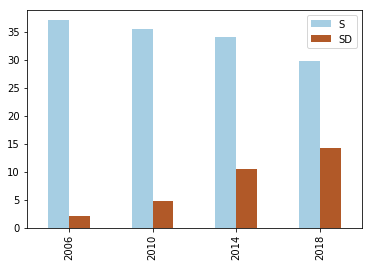

In [153]:
party_mandate_counter(df,party='SD',compare_party='S',plot=True)


Följande sparar en png av ploten:

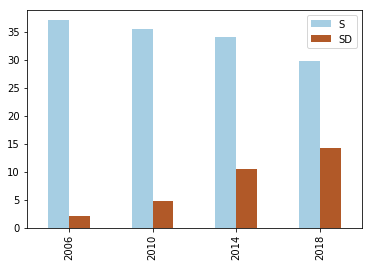

In [154]:
plot = party_mandate_counter(df,party='SD',compare_party='S',plot=True)
plot.get_figure().savefig("redaktionsmaterial/valdata/PÅHL_SD/3_SD_mandat/SD_jämf_S_mandat.png")

##### 3.6.4.1 Till grafik

In [155]:
grafik = party_mandate_counter(df,party='SD',plot=False)

In [156]:
grafik.rename(columns={'mandat':'SD:s kommunmandat',
                       'summa_mandat':'Mandat i alla kommuner',
                       'andelar_mandat':'SD:s andel av alla mandat'},
             inplace=True)

In [157]:
grafik.to_excel('redaktionsmaterial/tabeller_till_grafik/SD_så_gick_det_PÅHL/\
antal_mandat_för_SD.xlsx')

#### 3.6.5 De tio kommuner där SD ökade/tappade mest (jämf 2014)

'ascending=False' ger alla där de ökat mest.

In [158]:
muni_sorter(df,elec_year=elec_year, party='SD')\
    .sort_values(by=f'förändring_procent_{elec_year}_{elec_year-4}',ascending=True).head(10)

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018
258,Hagfors,Sverigedemokraterna,567,13.58,7.3,-6.28,5,3
208,Orsa,Sverigedemokraterna,497,14.93,10.8,-4.13,5,3
62,Falköping,Sverigedemokraterna,3664,21.11,17.2,-3.91,10,9
283,Sorsele,Sverigedemokraterna,48,6.40,3.2,-3.20,1,1
288,Arvidsjaur,Sverigedemokraterna,97,5.37,2.3,-3.07,2,1
74,Östra Göinge,Sverigedemokraterna,1454,18.92,16.2,-2.72,6,6
77,Borlänge,Sverigedemokraterna,5318,18.77,16.1,-2.67,12,10
194,Habo,Sverigedemokraterna,867,14.05,11.4,-2.65,5,4
214,Storfors,Sverigedemokraterna,274,12.95,10.3,-2.65,4,3
221,Norberg,Sverigedemokraterna,363,12.31,9.8,-2.51,4,4


In [159]:
muni_sorter(df,elec_year=elec_year, party='SD')\
    .sort_values(by=f'förändring_procent_{elec_year}_{elec_year-4}',ascending=False)\
    .to_excel(f'redaktionsmaterial/valdata/PÅHL_SD/4_SD_mest_ökning_minskning/\
procentförändring_SD_{elec_year}.xlsx',index=False)

Följande är en grundfil åt researchen ifall något skulle behöva dubbelkollas inför publicering:

In [161]:
all_elec_years('K').to_excel('redaktionsmaterial/valdata/PÅHL_SD/grundfil/grundfil.xlsx',index=False)

##### 3.6.5.1 Till grafik

In [162]:
party_kommuner(elec_year=elec_year,sorter=False,party='SD')\
    .to_excel(f"redaktionsmaterial/tabeller_till_grafik/SD_så_gick_det_PÅHL/\
tio_kommuner_SD_ökade_mest.xlsx",index=False)

party_kommuner(elec_year=elec_year,sorter=True,party='SD')\
    .to_excel(f"redaktionsmaterial/tabeller_till_grafik/SD_så_gick_det_PÅHL/\
tio_kommuner_SD_minskade_mest.xlsx",index=False)

#### 3.6.6 README

In [160]:
with open("redaktionsmaterial/valdata/PÅHL_SD/README.txt","w") as f:
    f.write("""\

I denna mapp finns fyra undermappar. Här är en kortare \
beskrivning av deras innehåll:

1_SD_största_parti

I denna mapp finns en huvudfil som visar alla partier \
som blev största parti i någon kommun, samt i hur många \
kommuner de blev så. I mappen 'per_parti' kan man sedan \
kolla in respektive parti som blev största parti, i vilka \
kommuner de blev så - samt vilken procent de där fick.

2_SD_resultat_totalt

Här är en rak tabell på alla partiers resultat i kommun-\
valet i riket (dvs summerat per parti).

3_SD_mandat

I denna tabell ser man hur många mandat SD har fått \
jämfört totalt antal mandat i alla kommuner per år, \
åren 2006-2018. Det finns också en graf som jämför \
SD med Socialdemokraternas mandat i alla kommuner.

4_SD_mest_ökning_minskning

Denna fil är en tabell över SD:s valresultat i alla \
kommuner, sorterad efter hur det gick i valet jämfört \
förra.

Vid frågor ang statistik, mejla mig (johan.ekman@dagenssamhalle.se) \
eller Gustav Halth (gustav.halth@dagenssamhalle.se).

""")
    f.close

## 3.7 De sista majoritetskommuner?

#### 3.7.1 Intro

Reporter: Johan D

Att ta fram:
- Partier som i en kommun fått över hälften av alla röster och/eller över hälften av alla mandat, i valen 2010, 2014 och 2018. Alla sådana partier i respektive kommun.


Inför valet såg Socialdemokraternas valresultat ut att bli historiskt lågt. En tanke var därför att se ifall det efter valet skulle finnas några kommuner kvar där de skulle ha egen majoritet. Följande kod kollar upp vilka kommuner där ett parti får majoritet - antingen via mandat eller via procent.

#### 3.7.2 Bearbetning

In [163]:
from util import all_elec_years,majority_counter

In [164]:
df = all_elec_years('K')

Ovanstående funktion har flera sätt att plocka fram datan. Först och främst, en rak tabell på alla kommuner som hade ett parti i majoritet efter något av valen. Notera funktionens argument:

In [165]:
majority_counter(df,years=[2018],operator='procent',plot=False,table=True)

,kommun,parti,procent,valår
12040,Överkalix,S,53.2,2018.0
12359,Vellinge,M,50.5,2018.0
13091,Grums,S,56.3,2018.0
13168,Munkfors,S,63.5,2018.0


In [166]:
elec_year=2018

In [167]:
majority_counter(df,years=[elec_year],operator='procent',plot=False,table=True)\
    .to_excel(f'redaktionsmaterial/valdata/JOHAN_majoritetskommunerna/\
1_kommuner_med_majoritetsstyre_procent_{elec_year}.xlsx',index=False)

Vi kan också få en sammanfattad tabell över alla år:

In [168]:
majority_counter(df,operator='procent',plot=False,table=False)

,valår,antal_med_majoritetsparti
0,2006,28
0,2010,26
0,2014,10
0,2018,4


Vi kan också välja ifall vi vill få fram procent, eller mandat genom parametern 'operator':

In [169]:
majority_counter(df,operator='mandat',plot=False,table=False)

,valår,antal_med_majoritetsparti
0,2006,32
0,2010,29
0,2014,13
0,2018,4


In [170]:
majority_counter(df,operator='procent',plot=False,table=False)\
    .rename(columns={'antal_med_majoritetsparti':'antal_med_majoritetsparti_procent'})\
    .merge(majority_counter(df,operator='mandat',plot=False,table=False)\
               .rename(columns={'antal_med_majoritetsparti':'antal_med_majoritetsparti_mandat'}),
           on='valår',how='left')\
    .to_excel(f'redaktionsmaterial/valdata/JOHAN_majoritetskommunerna/\
2_SAMMANFATTNING_2006_2018.xlsx',index=False)

Vi kan också skapa en enklare plot av ovanstående tabell, dvs samtliga kommuner där det finns ett parti med majoritet:

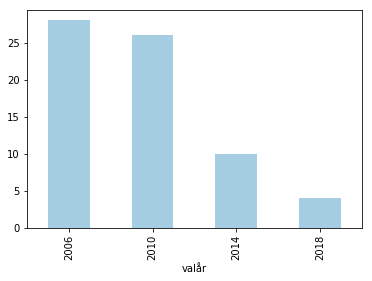

In [171]:
majority_counter(df,operator='procent',plot=True,table=False)

Slutligen, vi kan också se vilka partier som innehar dessa majoritetsstyren är i ett stapeldiagram:

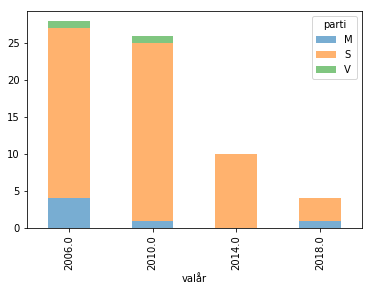

In [172]:
majority_counter(df,operator='procent',plot=True,table=True)

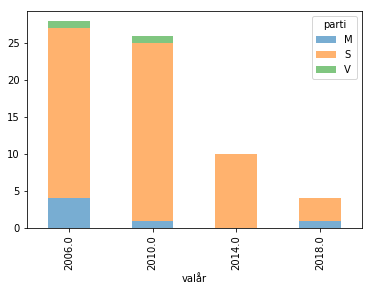

In [173]:
plot = majority_counter(df,operator='procent',plot=True,table=True)
plot.get_figure().savefig("redaktionsmaterial/valdata/JOHAN_majoritetskommunerna/3_antal_majoritetskommuner_partier.png")

Följande är en grundfil till researchen:

In [175]:
all_elec_years('K').to_excel('redaktionsmaterial/valdata/JOHAN_majoritetskommunerna/grundfil/grundfil.xlsx',index=False)

##### 3.7.2.1 Till grafik

In [176]:
df = all_elec_years('K')

In [177]:
elec_years=[2018]

In [178]:
grafik=majority_counter(df,years=elec_years,operator='mandat',plot=False,table=True)

In [179]:
grafik.head()

,kommun,mandat,parti,valår
12040,Överkalix,14.0,S,2018.0
12359,Vellinge,26.0,M,2018.0
13091,Grums,17.0,S,2018.0
13168,Munkfors,14.0,S,2018.0


In [180]:
grafik=grafik.loc[:,['parti','kommun','mandat']]

In [181]:
grafik.to_excel(f"redaktionsmaterial/tabeller_till_grafik/sista_majoritetskommunerna_JOHAN_D/\
kommuner_med_majoritetsparti.xlsx",index=False)

In [182]:
grafik=majority_counter(df,operator='mandat',plot=False,table=False)

In [183]:
grafik=grafik.rename(columns={'antal_med_majoritetsparti':'Antal kommuner med ett majoritetsparti'})

In [184]:
grafik.to_excel(f"redaktionsmaterial/tabeller_till_grafik/sista_majoritetskommunerna_JOHAN_D/\
antal_kommuner_m_majoritetsstyren_2006_2018.xlsx",index=False)

#### 3.7.3 README

In [174]:
with open("redaktionsmaterial/valdata/JOHAN_majoritetskommunerna/README.txt","w") as f:
    f.write("""\

I denna mapp finns tre filer. Här är en kortare \
beskrivning av deras innehåll:

1_kommuner_med_majoritetsstyre_procent_2014.xlsx

Här hittar man alla kommuner som har ett majoritetsstyre, \
samt vilket parti som innehar majoriteten. Om filen är \
tom så betyder det att dt inte fanns några majoritets-\
kommuner det året.

2_SAMMANFATTNING_2006_2018.xlsx

Här finns siffror på hur många kommuner som hade ett \
majoritetsstyre 2006-2018. Majoritet är här räknat på \
ifall man fick över 50 procent av väljarna.

3_antal_majoritetskommuner_partier.png

Här är ett simpelt diagram som visualiserar hur \
fördelningen av majoritetsstyrena sett ut, vilka \
partier som hade sådana styren.

""")
    f.close

## 3.8 Fi - kom de in/åkte ut?

#### 3.8.1 Intro

Reporter: Cissi

Att ta fram:
1. Antal mandat för Fi i kommunvalet 2018 jämfört 2014. 
2. Antal kommuner där de finns representerade valet 2018, jämfört 2014.
3. Kommuner där de kommit in/åkt ut i valet 2018.
4. Fi:s andel av rösterna i alla kommuner 2018, jämfört 2014.
5. Antal mandat för Fi i landstingsvalet 2018 jämfört 2014. 
6. Antal landsting där de finns representerade valet 2018, jämfört 2014.
7. Landsting där de kommit in/åkt ut i valet 2018.
8. Fi:s andel av rösterna i alla landsting 2018, jämfört 2014.

Data:
- Mandat/röster totalt och för Fi i kommunvalen 2018 och 2014.
- Mandat/röster totalt och för Fi i landstingsvalen 2018 och 2014.


In [1]:
from util import all_elec_years,\
                party_mandate_counter,\
                got_in_gov,\
                representation_FI,\
                totalprocent_jämförare,\
                parti_till_grafik,\
                muni_sorter

In [2]:
elec_year=2018

#### 3.8.2 Antal mandat för Fi i kommunvalet 2018 jämfört 2014. 

In [187]:
df = all_elec_years('K')

In [188]:
party_mandate_counter(df,party='FI',plot=False)

FI,mandat,summa_mandat,andelar_mandat
2006,0,13092,0.0
2010,4,12978,0.0
2014,26,12780,0.2
2018,22,12700,0.2


In [189]:
party_mandate_counter(df,party='FI',plot=False)\
    .to_excel("redaktionsmaterial/valdata/CISSI_FI/1_FIs_mandat/FIs_mandat_2006_2018.xlsx")

##### 3.8.2.1 Till grafik

In [190]:
df = all_elec_years('K')

In [191]:
grafik=party_mandate_counter(df,party='FI',plot=False)

In [192]:
grafik

FI,mandat,summa_mandat,andelar_mandat
2006,0,13092,0.0
2010,4,12978,0.0
2014,26,12780,0.2
2018,22,12700,0.2


In [193]:
grafik=grafik.reset_index().loc[:,['index','mandat']]\
    .rename(columns={'index':'Valår','mandat':'Antal mandat, FI'})

In [194]:
grafik.to_excel("redaktionsmaterial/tabeller_till_grafik/FI_hur_det_gick_CISSI/\
FIs_mandat_2006_2018.xlsx",index=False)

#### 3.8.3 Antal kommuner där FI finns representerade valet 2018, jämfört 2014.

Följande funktion kräver funktionen muni_sorter() för att fungera.

In [195]:
got_in_gov(val='K',elec_year=2018,party='FI',results='in').head()

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018
2,Vilhelmina,Feministiskt initiativ,173,0.07,4.0,3.93,0,1
4,Strömstad,Feministiskt initiativ,261,0.10,3.4,3.30,0,1
9,Gnesta,Feministiskt initiativ,165,0.33,2.3,1.97,0,1
11,Ödeshög,Feministiskt initiativ,78,0.11,2.2,2.09,0,1


In [196]:
got_in_gov(val='K',elec_year=2018,party='FI',results='in').shape[0]

4

FI kom in i 4 kommuner år 2014.

In [197]:
df = all_elec_years('K')

In [198]:
elec_year=[2018]

In [199]:
representation_FI(all_elec_years('K'),elec_years=elec_year)\
    .to_excel(f'redaktionsmaterial/valdata/CISSI_FI/2_FIs_kommuner/\
kommuner_med_fi_{elec_year[0]}.xlsx',index=False)

Här sparas en fil för de kommuner där fi kom in, en för de kommuner där de åkte ut:

In [200]:
got_in_gov(val='K',elec_year=elec_year[0],party='FI',results='in')\
    .to_excel(f'redaktionsmaterial/valdata/CISSI_FI/2_FIs_kommuner/\
kommuner_där_FI_kom_in_{elec_year}.xlsx',index=False)
got_in_gov(val='K',elec_year=elec_year[0],party='FI',results='ut')\
    .to_excel(f'redaktionsmaterial/valdata/CISSI_FI/2_FIs_kommuner/\
kommuner_där_FI_åkte_ur_{elec_year}.xlsx',index=False)

#### 3.8.4 Kommuner där de kommit in/åkt ut i valet 2018.

In [203]:
got_in_gov(val='K',elec_year=elec_year[0],party='FI',results='ut').head()

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018
12,Umeå,Feministiskt initiativ,1750,3.90,2.1,-1.80,3,0
14,Malmö,Feministiskt initiativ,3825,3.23,1.9,-1.33,2,0
19,Norrköping,Feministiskt initiativ,1247,1.66,1.4,-0.26,1,0
18,Sala,Feministiskt initiativ,214,2.00,1.4,-0.60,1,0


FI åkte ur KF i fyra kommuner 2018.

#### 3.8.5 Fi:s andel av rösterna i alla kommuner 2018, jämfört 2014.

In [3]:
df = all_elec_years('K')

In [5]:
elec_year=2018

In [207]:
totalprocent_jämförare(df,elec_year=elec_year,elec_type='K')

,procent_2018,röster_2018,procent_2014,röster_2014
parti,,,,
C,9.5,628870,7.7,489381
FI,0.9,61575,1.2,76646
KD,5.1,337476,3.9,248070
L,6.7,442623,6.5,408175
M,19.7,1302561,21.3,1343586
MP,4.5,300079,7.7,483529
S,27.1,1790500,30.8,1947473
SD,12.5,825822,9.2,581476
V,7.5,498620,6.4,401531


In [208]:
totalprocent_jämförare(df,elec_year=elec_year,elec_type='K')\
    .to_excel(f"redaktionsmaterial/valdata/CISSI_FI/3_FIs_röstandelar/\
valresultat_riket.xlsx")

##### 3.8.5.1 Till grafik

In [2]:
df = all_elec_years('K')

In [6]:
grafik=parti_till_grafik(df,elec_type='K',elec_year=elec_year,party='FI')

grafik=grafik.rename(columns={'FI':f'FI:s resultat i kommunvalen {elec_year}, %'})

grafik.to_excel("redaktionsmaterial/tabeller_till_grafik/FI_hur_det_gick_CISSI/\
FIs_valresultat_kommunvalet.xlsx")

In [7]:
grafik

Parti,"FI:s resultat i kommunvalen 2018, %"
2018,0.9
2014,1.2
"Differens, %",-0.3


In [8]:
df = all_elec_years('L')

In [9]:
grafik=parti_till_grafik(df,elec_type='L',elec_year=elec_year,party='FI')

grafik=grafik.rename(columns={'FI':f'FI:s resultat i landstingsvalen {elec_year}, %'})

grafik.to_excel("redaktionsmaterial/tabeller_till_grafik/FI_hur_det_gick_CISSI/\
FIs_valresultat_landstingen.xlsx")

In [10]:
grafik

Parti,"FI:s resultat i landstingsvalen 2018, %"
2018,0.6
2014,1.1
"Differens, %",-0.5


#### 3.8.6 Antal mandat för Fi i landstingsvalet 2018 jämfört 2014.

Ovanstående funktion (som bygger på funktionen muni_sorter()) tar parametern 'val' som kan bestämma vilket val som ska undersökas:

In [11]:
df = all_elec_years('L')

In [12]:
party_mandate_counter(df,party='FI',plot=False)

FI,mandat,summa_mandat,andelar_mandat
2006,0,0,NaN
2010,0,1662,0.0
2014,0,1678,0.0
2018,0,1696,0.0


Bättre är dock att använda muni_sorter() som lika gärna tar landastingsdata:

In [13]:
muni_sorter(df,
            elec_year=elec_year,
            party='FI',
            sort_variabel='procent')

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018
0,Stockholms län,Feministiskt initiativ,15220,2.59,1.1,-1.49,0,0
1,Uppsala län,Feministiskt initiativ,2626,2.17,1.1,-1.07,0,0
2,Västra Götalands län,Feministiskt initiativ,8615,0.36,0.8,0.44,0,0
3,Västerbottens län,Feministiskt initiativ,1451,2.13,0.8,-1.33,0,0
4,Skåne län,Feministiskt initiativ,6111,1.64,0.7,-0.94,0,0
5,Värmlands län,Feministiskt initiativ,834,0.17,0.5,0.33,0,0
6,Blekinge län,Feministiskt initiativ,477,0.10,0.5,0.40,0,0
7,Örebro län,Feministiskt initiativ,721,1.23,0.4,-0.83,0,0
8,Östergötlands län,Feministiskt initiativ,1122,0.22,0.4,0.18,0,0
13,Västernorrlands län,Feministiskt initiativ,508,0.15,0.3,0.15,0,0


In [14]:
muni_sorter(df,
            elec_year=elec_year,
            party='FI',
            sort_variabel='procent')\
    .to_excel(f"redaktionsmaterial/valdata/CISSI_FI/4_FIs_mandat_landstinget/\
valresultat_FI_landstingen.xlsx",index=False)

#### 3.8.7 Antal landsting där de finns representerade valet 2018, jämfört 2014.

Här kan vi använda samma funktion som i punkt 2 ovan:

In [16]:
elec_years=[2014,2018]

In [17]:
representation_FI(all_elec_years('L'),elec_years=elec_years,party='FI')\
    .to_excel(f"redaktionsmaterial/valdata/CISSI_FI/5_FIs_representation_landstinget/\
alla_landsting_med_FI_{elec_years[0]}_{elec_years[1]}.xlsx",index=False)

In [18]:
got_in_gov(val='L',elec_year=elec_year,party='FI',results='in')

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018


FI kom inte in i något landsting.

In [19]:
got_in_gov(val='L',elec_year=2018,party='FI',results='in').shape[0]

0

#### 3.8.8 Landsting där de kommit in/åkt ut i valet 2018.

I punkt 6 ovan så ser vi var de kommit in, följande är var de åkte ut:

In [20]:
got_in_gov(val='L',elec_year=elec_year,party='FI',results='ut').head()

,kommun,beteckning,röster,procent_2014,procent_2018,förändring_procent_2018_2014,mandat_2014,mandat_2018


De åkte inte ur någonstans då de inte satt i något landsting 2014.

#### 3.8.9 Fi:s andel av rösterna i alla landsting 2018, jämfört 2014.

In [21]:
df = all_elec_years('L')

In [22]:
totalprocent_jämförare(df,elec_year=elec_year,elec_type='L')

,procent_2018,röster_2018,procent_2014,röster_2014
parti,,,,
C,8.2,537254,6.2,387555
FI,0.6,41760,1.1,66600
KD,7.0,455865,5.1,317270
L,6.2,402775,6.2,385999
M,18.9,1236378,21.2,1321172
MP,4.0,264426,7.1,442760
S,28.2,1842453,32.3,2020476
SD,12.6,824599,9.0,561611
V,8.4,552349,7.0,434992


In [23]:
totalprocent_jämförare(df,elec_year=elec_year,elec_type='L')\
    .to_excel(f'redaktionsmaterial/valdata/CISSI_FI/6_FIs_röstandelar_landstinget_totalt/\
resultat_landstingen_{elec_year}.xlsx')

#### 3.8.10 README

In [24]:
with open("redaktionsmaterial/valdata/CISSI_FI/README.txt","w") as f:
    f.write("""\

Här en kortare beskrivning på mappens innehåll:

1_FIs_mandat

Sammanfattning av FIs mandat i Sveriges kommuner \
valen 2006-2018.

2_FIs_kommuner

Tre filer. En med alla kommuner där FI åkte ur i valet. \
En med kommunerna där de kom in iom valet. En med alla \
kommuner där de iom valet har representation. Ifall \
filerna är tomma så betyder det att de inte åkte ur/kom \
in, eller har någon representation.

3_FIs_röstandelar

Rak lista på alla partiers resultat i kommunvalet \
i hela Sverige, inkl FI.

4_mandat_landstinget

Tabell på FIs valresultat i alla landsting jämfört \
förra valet.

5_FIs_representation_landstinget

Alla landsting där FI fick mandat detta och förra valet.

6_röstandelar_landstinget_totalt

Sammanfattat valresultat i landstingen för alla \
partier, inkl FI.

""")
    f.close

## 3.9 De lokala partierna

#### 3.9.1 Intro

Reporter: Samuel

Att ta fram:
1. De lokala partier som har störst andel röster i sin egen kommun. Ta bort de som inte fått mandat.

Data:
- Röster och totalt antal röster i alla kommuner för alla partier som inte är något av riksdagspartierna

Följande partier är "lokala" i att de bara ställer upp i kommunvalet, men de är egentligen rikspartier och ska därför bort ur vår sammanställning.

#### 3.9.2 Bearbetning

In [25]:
import pandas as pd
from util import local_parties,all_elec_years

In [26]:
bort=['Landsbygdspartiet Oberoende',
 'SPI Välfärden',
 'Kommunistiska Partiet',
 'Medborgerlig Samling']

In [27]:
partier=pd.read_excel('data/resultat/alla_partier.xlsx')

In [28]:
partier.head()

,val,parti,beteckning
0,2010K,0247,Malmöpartiet
1,2010K,0333,Silverfox-partiet
2,2010K,0339,Sveriges Nationella Demokratiska Parti
3,2010K,0450,Framtidspartiet Sverige
4,2010K,0470,Seniorpartiet


In [29]:
bort=partier.loc[(partier['beteckning'].isin(bort))&(partier['val']=='2018K'),'parti']

In [30]:
df = all_elec_years('K')

In [31]:
elec_year=2018

In [32]:
test=local_parties(df,elec_year=elec_year,elec_type='K',sorter=False)

In [33]:
test.head()

,kommun,beteckning,procent_2018,mandat_2018,kommunmandat_totalt
92,Hagfors,OBEROENDE REALISTER,36.4,13.0,35
74,Nykvarn,Nykvarnspartiet,30.5,9.0,31
58,Perstorp,Perstorps Framtid,29.9,11.0,35
81,Vaxholm,Waxholmspartiet - borgerligt alternativ,24.7,8.0,31
56,Båstad,Bjärepartiet,22.2,9.0,41


In [34]:
local_parties(df,elec_year=elec_year,elec_type='K',sorter=False)\
    .to_excel(f"redaktionsmaterial/valdata/SAMUEL_lokala_partier/\
valresultat_lokala_partier_{elec_year}.xlsx",index=False)

##### 3.9.2.1 Till grafik

In [36]:
df = all_elec_years('K')

In [37]:
grafik=local_parties(df,elec_year=elec_year,elec_type='K',sorter=False).head(15)

In [38]:
grafik=grafik.loc[:,['kommun','beteckning',f'procent_{elec_year}']]

In [39]:
grafik.rename(columns={'kommun':'Kommun',
                       'beteckning':'Parti',
                       f'procent_{elec_year}':'Kommunvalet, %'},inplace=True)

In [40]:
grafik

,Kommun,Parti,"Kommunvalet, %"
92,Hagfors,OBEROENDE REALISTER,36.4
74,Nykvarn,Nykvarnspartiet,30.5
58,Perstorp,Perstorps Framtid,29.9
81,Vaxholm,Waxholmspartiet - borgerligt alternativ,24.7
56,Båstad,Bjärepartiet,22.2
135,Vadstena,Konsensus - För Vadstenas Bästa,22.1
111,Lysekil,Lysekilspartiet,21.0
104,Sollefteå,Västra Initiativet,18.6
24,Åre,Västjämtlands Väl,18.6
97,Dorotea,Dorotea Kommunlista,18.4


In [41]:
grafik.to_excel("redaktionsmaterial/tabeller_till_grafik/de_lokala_partierna_SAMUEL/\
15_största_lokala_partierna.xlsx",index=False)

#### 3.9.3 README

In [35]:
with open("redaktionsmaterial/valdata/SAMUEL_lokala_partier/README.txt","w") as f:
    f.write("""\

Den här filen visar valresultatet för alla lokala partier. \
Endast lokala partier som fått mandat är medräknade. FI är \
inte med i beräkningen.

""")
    f.close

## 3.10 Här lockades flest till valbåsen

#### 3.10.1 Intro

Reporter: Måns

Att ta fram:
- Valdeltagande per kommun, valen 2018 och 2014
- De tio kommuner där valdeltagandet ökat mest
- De tio kommuner där valdeltagandet minskat mest


Denna funktion sorterar fram data på valdeltagande för valfritt valår. Parametern 'value_sorter' bestämmer efter vilken column som den ska sorteras, efter högst/lägst valdeltagande, eller efter förändring.

#### 3.10.2 Bearbetning

In [42]:
import pandas as pd
from util import particip_sorter,elec_particip,kommun_deltagande

In [43]:
elec_year = 2018

In [44]:
particip_sorter(elec_year=elec_year,elec_type='K',value_sorter='förändring',sorter=False).head()

,kommun,valdeltagande_2014,valdeltagande_2018,förändring_2014-2018
94,Båstad,63.6,86.6,23.0
221,Mellerud,78.9,82.5,3.6
217,Bengtsfors,78.0,81.3,3.3
92,Malmö,75.2,78.5,3.3
222,Munkedal,81.3,84.5,3.2


Ovan kan man se en potentiell brist som kommer genom att kolla valresultatsdata - ibland sker det omval. I detta fall så ser vi att valresultatet för 2014 i Båstad var endast 63,6 procent. Det är inte för att man sket i kommunvalet där 2014, det är för att det var ett omval i juni 2015 i Båstad för kommunfullmäktige. Det här ordnades ad hoc inför publiceringen i tidningen.

In [45]:
particip_sorter(elec_year=elec_year,elec_type='K',value_sorter='förändring',sorter=False)\
    .to_excel(f'redaktionsmaterial/valdata/MÅNS_valdeltagande/\
valdeltagande_{elec_year}_jämfört_{elec_year-4}.xlsx',index=False)

In [46]:
pd.read_excel(f'data/meta_filer/valdeltagande/\
valdeltagande_{elec_year}K.xlsx')\
.to_excel("redaktionsmaterial/valdata/MÅNS_valdeltagande/grundfiler/grundfil.xlsx",index=False)

##### 3.10.2.1 Till grafik

In [48]:
grafik=elec_particip('K')

grafik=grafik.loc[grafik['Valår']>2010].set_index('Valår')

grafik=grafik.T

grafik['Differens'] = grafik[2018]-grafik[2014]

In [49]:
grafik

Valår,2014,2018,Differens
"Valdeltagande, %",82.8,84.1,1.3


In [50]:
grafik.to_excel('redaktionsmaterial/tabeller_till_grafik/valdeltagande_MÅNS/\
valdeltagande_kommunvalet_totalt.xlsx')

In [52]:
elec_year=2018

In [53]:
kommun_deltagande(elec_year,'K',sorter=False)

,kommun,"Valdeltagande, %",Differens
94,Båstad,86.6,23.0
221,Mellerud,82.5,3.6
217,Bengtsfors,81.3,3.3
92,Malmö,78.5,3.3
222,Munkedal,84.5,3.2
40,Krokom,86.3,3.1
121,Hörby,84.1,3.1
225,Strömstad,76.7,3.0
111,Skurup,85.5,2.9
110,Sjöbo,83.5,2.8


In [54]:
kommun_deltagande(elec_year,'K',sorter=False)\
    .to_excel('redaktionsmaterial/tabeller_till_grafik/valdeltagande_MÅNS/\
störst_ökning_10_kommuner.xlsx',index=False)
kommun_deltagande(elec_year,'K',sorter=True)\
    .to_excel('redaktionsmaterial/tabeller_till_grafik/valdeltagande_MÅNS/\
störst_minskning_10_kommuner.xlsx',index=False)

#### 3.10.3 README

In [47]:
with open("redaktionsmaterial/valdata/MÅNS_valdeltagande/README.txt","w") as f:
    f.write("""\

I denna fil finner man valdeltagandet i valet, jämfört \
med förra. Det är sorterat efter de kommuner som hade \
störst ökning i valdeltagande.

""")
    f.close

## 3.11 Så gick valet i storstäderna

#### 3.11.1 Intro

Reporter: Påhl

Att ta fram:
- Mandatfördelning för alla partier i Stockholm, Göteborg och Malmö

#### 3.11.2 Bearbetning

In [55]:
import pandas as pd
from util import big_city_sort,storstäderna_grafik

In [56]:
elec_year = 2018

In [57]:
test=big_city_sort(elec_year=elec_year,elec_type='K')

In [58]:
test=test.merge(big_city_sort(elec_year=2014,elec_type='K'),on=['kommun','parti'],how='left')

In [59]:
test.loc[:,['kommun','parti','mandat_2014','mandat_2018']]

,kommun,parti,mandat_2014,mandat_2018
0,Malmö,M,14.0,13.0
1,Malmö,C,0.0,3.0
2,Malmö,L,3.0,4.0
3,Malmö,KD,0.0,0.0
4,Malmö,S,21.0,20.0
5,Malmö,V,6.0,7.0
6,Malmö,MP,6.0,3.0
7,Malmö,SD,9.0,11.0
8,Malmö,FI,2.0,0.0
9,Stockholm,M,28.0,22.0


In [60]:
big_city_sort(elec_year=elec_year,elec_type='K')\
    .to_excel(f"redaktionsmaterial/valdata/PÅHL_storstäderna/\
valresultat_storstäderna_{elec_year}.xlsx",index=False)

##### 3.11.2.1 Till grafik

In [62]:
grafik=big_city_sort(elec_year=elec_year,elec_type='K')

In [63]:
städer=['Malmö','Stockholm','Göteborg']

In [64]:
for stad in städer:
    storstäderna_grafik(grafik,stad=stad,elec_year=elec_year)\
        .to_excel(f'redaktionsmaterial/tabeller_till_grafik/storstäderna_PÅHL/\
{stad}_mandatresultat.xlsx',index=False)

#### 3.11.3 README

In [61]:
with open("redaktionsmaterial/valdata/PÅHL_storstäderna/README.txt","w") as f:
    f.write("""\

I denna excelfil finner man valresultatet i storstäderna.

""")
    f.close

## 3.12 Valets förlorare

#### 3.12.1 Intro

Reporter: Hans

Att ta fram:
- De tio kommuner där tappet i röstandelar för ett parti är högst i landet

Data:
1. röstandelar för varje parti i varje kommun i valen 2014 och 2018 (resultatet blir då valet 2018 minus 2014, sortera kommunerna efter störst tapp).

#### 3.12.2 Bearbetning

In [65]:
from util import looser_winner,all_elec_years

In [66]:
elec_year=2018

In [67]:
df = all_elec_years('K')

In [68]:
looser_winner(df,elec_year=elec_year,party=None,sorter=True).head()

,kommun,beteckning,röster_2018,procent_2014,procent_2018,diff i procentenheter 2018-2014,mandat_2014,mandat_2018
544,Dorotea,Dorotea Kommunlista,301,38.97,18.4,-20.57,10,5
2007,Övertorneå,Övertorneås Fria Alternativ,90,21.76,3.4,-18.36,7,1
609,Åsele,Åselepartiet,305,35.16,16.9,-18.26,11,6
205,Pajala,Arbetarepartiet-Socialdemokraterna,1109,46.03,29.3,-16.73,15,8
216,Älvdalen,Arbetarepartiet-Socialdemokraterna,1355,45.51,28.9,-16.61,17,11


Ovanstående är en ombyggd variant av muni_sorter(). Med parametern part=None så återges samtliga kommuner och dess partier sorterad efter hur stor skillnad det var i stöd mellan angivet val och valet innan i procent. Man kan specificera parti också med t ex party='SD'.

In [69]:
looser_winner(df,elec_year=elec_year,party=None,sorter=True)\
    .to_excel(f"redaktionsmaterial/valdata/HANS_valförlorarna/\
största_tappen_{elec_years}.xlsx",index=False)

##### 3.12.2.1 Till grafik

Här sorteras de kommuner där de störst tapp av procent för ett parti (som ändock fortfarande finns representerat i KF efter valet 2018) skedde. 

In [71]:
df = all_elec_years('K')

In [72]:
elec_year=2018

In [73]:
grafik=looser_winner(df,elec_year=elec_year,party=None,sorter=True,stora_partier=False)

grafik = grafik.loc[grafik[f'mandat_{elec_year}']>0].head(10)

grafik=grafik.loc[:,['kommun','beteckning',f'procent_{elec_year}',f'diff i procentenheter {elec_year}-{elec_year-4}']]

grafik.rename(columns={'kommun':'Kommun',
                      'beteckning':'Parti',
                      f'procent_{elec_year}':'Resultat',
                      f'diff i procentenheter {elec_year}-{elec_year-4}':'Minskning'},inplace=True)

In [74]:
grafik

,Kommun,Parti,Resultat,Minskning
544,Dorotea,Dorotea Kommunlista,18.4,-20.57
2007,Övertorneå,Övertorneås Fria Alternativ,3.4,-18.36
609,Åsele,Åselepartiet,16.9,-18.26
205,Pajala,Arbetarepartiet-Socialdemokraterna,29.3,-16.73
216,Älvdalen,Arbetarepartiet-Socialdemokraterna,28.9,-16.61
80,Ragunda,Arbetarepartiet-Socialdemokraterna,35.6,-15.52
78,Hagfors,Arbetarepartiet-Socialdemokraterna,35.7,-14.90
802,Eda,Hela Edas Lista,13.4,-14.34
312,Vimmerby,Arbetarepartiet-Socialdemokraterna,25.1,-13.45
411,Östra Göinge,Arbetarepartiet-Socialdemokraterna,21.7,-13.05


In [75]:
grafik.to_excel("redaktionsmaterial/tabeller_till_grafik/förlorarna_HANS/\
10_största_förlorarna.xlsx",index=False)

#### 3.12.3 README

In [70]:
with open("redaktionsmaterial/valdata/HANS_valförlorarna/README.txt","w") as f:
    f.write("""\

I denna excelfil hittar man alla vinnare och förlorare i \
enskilda kommuner i Sveriges alla kommunval. Listan är \
sorterad efter alla de partier som hade störst tapp i \
procentuellt stöd i valet. 

""")
    f.close

## 3.13 Lokala röstmagneter

#### 3.13.1 Intro

Reporter: Anna L

Att ta fram:
- De partier som gått starkast i kommunvalet jämfört riksdagsvalet i samma kommun.

Data:
1. Röstandelar per parti i respektive kommun i kommunvalet och riksdagsvalet 2018


Lokala röstmagneter är en koll som DS har gjort flera gånger efter val. Det kontrolleras genom att se i vilken kommun där andelen röster för ett parti i en kommun skiljer sig i kommunvalet jämfört med riksdagsvalet. Ett klassiskt exempel är KD i Markaryd där de lokalt är ett väldigt starkt fäste, men där KD inte får lika många röster i riksdagsvalet.

#### 3.13.2 Bearbetning

In [76]:
from util import all_elec_years,local_magnates,elec_compare

In [77]:
local_magnates(elec_year=2018).head(15)

,kommun,parti,röster_K,procent_K,röster_R,procent_R,diff_K_jämf_R
127,Orsa,C,1922.0,41.9,505.0,11.1,30.8
2442,Laxå,KD,1413.0,39.1,342.0,9.4,29.7
568,Mönsterås,C,3496.0,39.0,888.0,10.0,29.0
1693,Nordmaling,C,1989.0,42.5,629.0,13.6,28.9
660,Markaryd,KD,2407.0,39.5,629.0,10.6,28.9
1109,Landskrona,L,9340.0,34.3,1794.0,6.7,27.6
766,Kiruna,C,4899.0,32.9,793.0,5.4,27.5
1963,Dals-Ed,C,1144.0,38.6,371.0,12.7,25.9
2399,Degerfors,V,2294.0,35.6,652.0,10.2,25.4
712,Arvidsjaur,C,1422.0,34.3,390.0,9.3,25.0


In [78]:
elec_year=2018

In [79]:
local_magnates(elec_year=elec_year)\
    .to_excel(f"redaktionsmaterial/valdata/ANNA_L_röstmagneter/\
röstmagneter_KOMMUNER_{elec_year}.xlsx",index=False)

##### 3.13.2.1 Till grafik

In [81]:
elec_year=2018

In [82]:
grafik=local_magnates(elec_year=elec_year).head(10)

grafik=grafik.loc[:,['kommun','parti','procent_R','procent_K','diff_K_jämf_R']]

grafik.rename(columns={
    'kommun':'Kommun',
    'parti':'Parti',
    'procent_R':'Riks',
    'procent_K':'Kommun',
    'diff_K_jämf_R':'Differens'
},inplace=True)

In [83]:
grafik

,Kommun,Parti,Riks,Kommun,Differens
127,Orsa,C,11.1,41.9,30.8
2442,Laxå,KD,9.4,39.1,29.7
568,Mönsterås,C,10.0,39.0,29.0
1693,Nordmaling,C,13.6,42.5,28.9
660,Markaryd,KD,10.6,39.5,28.9
1109,Landskrona,L,6.7,34.3,27.6
766,Kiruna,C,5.4,32.9,27.5
1963,Dals-Ed,C,12.7,38.6,25.9
2399,Degerfors,V,10.2,35.6,25.4
712,Arvidsjaur,C,9.3,34.3,25.0


In [84]:
grafik.to_excel('redaktionsmaterial/tabeller_till_grafik/lokala_röstmagneter_ANNA_L/\
lokala_röstmagneter.xlsx',index=False)

#### 3.13.3 README

In [80]:
with open("redaktionsmaterial/valdata/ANNA_L_röstmagneter/README.txt","w") as f:
    f.write("""\

I denna mapp finns det en fil som visar resultat i kommunerna. 

KOMMUNER

Här kan man se i vilka kommuner ett parti har över-/\
underträffat det resultat partiet hade i rikesdagsvalet \
i samma kommun. T ex så fick KD i Markaryd ett otroligt \
starkt resultat jämfört med vad de fick i riksdagsvalet \
i samma kommun (44,9 procent i kommunvalet 2014, 7,4 i \
riksdagsvalet 2014).


""")
    f.close

## 3.14 Webbtabeller till Datawrapper

#### 3.14.1 Intro

Till Nicklas Larson

Inför valnatten så planerades det två stycken tabeller som presenterade valresultatet i kommunvalet och i landstingsvalet. Dessa skulle publiceras på webben med hjälp av Datawrapper under morgonen måndagen efter valet. Nicklas är vår webbansvariga på redaktionen.

#### 3.14.2 Bearbetning

In [85]:
from util import till_datawrapper

In [86]:
parties = ['M','L','C','KD','S','V','MP','SD','FI','Övr']

In [87]:
elec_years=[2014,2018]

In [88]:
elec_types=['K','R']

In [89]:
df=till_datawrapper(elec_types=['K','R'],elec_years=elec_years)

In [90]:
df

val,Parti,"Resultat kommunvalen, %","Förändring jämfört 2014, %","Resultat riksdagsvalet, %"
0,C,9.7,1.8,8.6
1,FI,0.9,-0.3,0.5
2,KD,5.2,1.2,6.3
3,L,6.8,0.2,5.5
4,M,20.1,-1.4,19.8
5,MP,4.6,-3.2,4.4
6,S,27.6,-3.6,28.3
7,SD,12.7,3.4,17.5
8,V,7.7,1.3,8.0
9,Övr,4.7,0.6,1.0


In [91]:
for types in ['K','L']:
    till_datawrapper(elec_types=[types,'R'],elec_years=elec_years)\
        .to_excel(f"redaktionsmaterial/valdata/NICKLAS_datawrapper/\
valresultat_{types}.xlsx",index=False)

## 3.15 Övrigt

Följande är till researcher Gustav som tar fram valresultatet 2018: 

In [3]:
for elec in ['K','L','R']:
    df = all_elec_years(elec)
    df.loc[df['valår']==2018].to_excel(f'prelresultat_2018{elec}.xlsx',index=False)